In [1]:
import numpy as np
from experiments.hmm.classifier import StateClassifierNet
import torch as th
import torch.nn as nn
from pytorch_lightning import seed_everything
from tint.attr.models import ExtremalMaskNN
from tint.models import MLP, RNN
from tint.datasets.hmm_modified import HMM_modified
from forward import forward
import matplotlib.pyplot as plt

c:\Users\sebas\anaconda3\envs\tint\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
seed=42
seed_everything(seed=seed, workers=True)

Global seed set to 42


42

In [3]:
# Train classifier and Extremal mask explainer, store model weights
# %run experiments/hmm/main.py --explainers "extremal_mask" --deterministic --output-file "hmm_modified_results_per_fold.csv" --dataset_name "hmm_modified" --hidden_size 50
%run experiments/hmm/main.py --fold 0 --explainers "extremal_mask" --deterministic --output-file "hmm_modified_results_per_fold.csv" --dataset_name "hmm_modified" --hidden_size 50 

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


classifier has loaded the saved weights on hmm_modified dataset with fold = 0, if applicable, lambda 1 = 1.0 and lambda 2 = 1.0.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


preservation mode is  True
extremal_mask has loaded the saved weights on hmm_modified dataset with fold = 0, if applicable, lambda 1 = 1.0 and lambda 2 = 1.0.


In [4]:
### Get data
train_features = np.load('tint/data/hmm/train_features_modified.npz', allow_pickle= True)  
test_features = np.load('tint/data/hmm/test_features_modified.npz', allow_pickle= True)
train_labels = np.load('tint/data/hmm/train_labels_modified.npz', allow_pickle= True)

In [5]:
# Transform to tensors, check shape
x_train = th.tensor(train_features)
x_test = th.tensor(test_features)
print(type(x_train),x_train.shape)

<class 'torch.Tensor'> torch.Size([800, 50, 3])


In [6]:
### Get classifier         
# Create model
classifier = StateClassifierNet(
        feature_size=3,
        n_state=2,
        hidden_size=50,
        regres=True,
        loss="cross_entropy",
        lr=0.0001,
        l2=1e-3,
    )

# Load the state dictionary from the checkpoint file
checkpoint_path = 'experiments/checkpoints/hmm_modified_classifier_42_0.ckpt'       ### change path when using different hyperparameters
state_dict = th.load(checkpoint_path)

# Load the state dictionary into the model
classifier.load_state_dict(state_dict)

<All keys matched successfully>

In [7]:
# Sanity check
checkpoint_path = 'experiments/checkpoints/hmm_modified_extremal_mask_42_1.0_1.0_0.ckpt'           ### change path when using different hyperparameters

# Load the state dictionary
state_dict = th.load(checkpoint_path)

# Print keys and shapes in the state dictionary
for key, value in state_dict.items():
    print(f"{key}: {value.shape if isinstance(value, th.Tensor) else type(value)}")

net.mask: torch.Size([200, 50, 3])
net.model.0.rnn.weight_ih_l0: torch.Size([9, 3])
net.model.0.rnn.weight_hh_l0: torch.Size([9, 3])
net.model.0.rnn.bias_ih_l0: torch.Size([9])
net.model.0.rnn.bias_hh_l0: torch.Size([9])
net.model.0.rnn.weight_ih_l0_reverse: torch.Size([9, 3])
net.model.0.rnn.weight_hh_l0_reverse: torch.Size([9, 3])
net.model.0.rnn.bias_ih_l0_reverse: torch.Size([9])
net.model.0.rnn.bias_hh_l0_reverse: torch.Size([9])
net.model.1.mlp.Linear_0.weight: torch.Size([3, 6])
net.model.1.mlp.Linear_0.bias: torch.Size([3])


In [9]:
## using ExtremalMaskNN instead of Net 
EMNN = ExtremalMaskNN(forward_func=classifier,
        model=nn.Sequential(
                RNN(
                    input_size=x_train.shape[-1],        
                    rnn="gru",
                    hidden_size=x_train.shape[-1],
                    bidirectional=True,
                ),
                MLP([2 * x_train.shape[-1], x_train.shape[-1]]),
            ),
        batch_size= 32)

mask = nn.Parameter(th.Tensor([200,50,3]))

# Load the state dictionary from the checkpoint file
checkpoint_path = 'experiments/checkpoints/hmm_modified_extremal_mask_42_1.0_1.0_0.ckpt'       ### change path when using different hyperparameters
state_dict = th.load(checkpoint_path)

filtered_state_dict_mask =  {key: value for key, value in state_dict.items() if key == 'net.mask'}
filtered_state_dict_model = {key[4:]: value for key, value in state_dict.items() if key !='net.mask'} 

# Load the state dictionary into the model
#print(EMNN.named_parameters)
for name, param in EMNN.named_parameters():
    print(f"Parameter: {name}, Shape: {param.shape}")

EMNN.load_state_dict(filtered_state_dict_model)
#mask.load_state_dict(filtered_state_dict_mask)
mask = state_dict['net.mask']

Parameter: model.0.rnn.weight_ih_l0, Shape: torch.Size([9, 3])
Parameter: model.0.rnn.weight_hh_l0, Shape: torch.Size([9, 3])
Parameter: model.0.rnn.bias_ih_l0, Shape: torch.Size([9])
Parameter: model.0.rnn.bias_hh_l0, Shape: torch.Size([9])
Parameter: model.0.rnn.weight_ih_l0_reverse, Shape: torch.Size([9, 3])
Parameter: model.0.rnn.weight_hh_l0_reverse, Shape: torch.Size([9, 3])
Parameter: model.0.rnn.bias_ih_l0_reverse, Shape: torch.Size([9])
Parameter: model.0.rnn.bias_hh_l0_reverse, Shape: torch.Size([9])
Parameter: model.1.mlp.Linear_0.weight, Shape: torch.Size([3, 6])
Parameter: model.1.mlp.Linear_0.bias, Shape: torch.Size([3])


(array([21100.,   218.,   229.,   274.,   284.,   358.,   463.,   664.,
         1035.,  5375.]),
 array([-0.00901446,  0.09286568,  0.19474581,  0.29662594,  0.39850608,
         0.50038618,  0.60226631,  0.70414644,  0.80602658,  0.90790671,
         1.00978684]),
 <BarContainer object of 10 artists>)

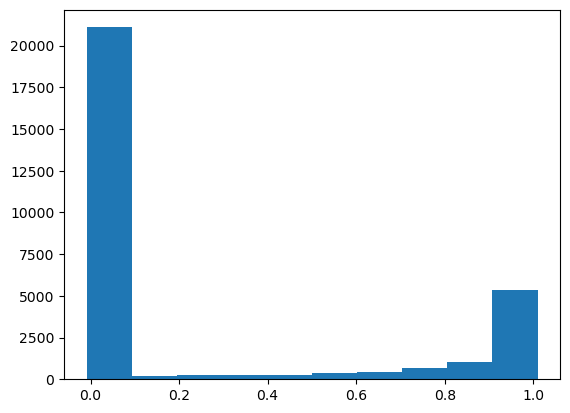

In [10]:
plt.hist(mask.view(-1))

In [11]:
def perturb(x,m,x_):
    return m*x + (1-m)*x_ 

In [12]:
hmm = HMM_modified(n_folds=5, fold=1, seed=seed)      ### set the right fold

In [13]:
# Apply forward algorithm to get log probabilities of test set datapoints and their perturbations

N = x_test.shape[0]
p = np.zeros(shape=(N,2))
l = np.zeros(shape=(N,2))
for i in range(N):    
    x = x_test[i].to(th.float32)
    #print(type(x))
    x_ = EMNN.model(x)  ### baselines are 0 by default
    x_p = perturb(x,mask[i],x_) 
    x = x.detach().numpy()
    x_p = x_p.detach().numpy()
    p[i,0] = forward(hmm, x)[1]
    p[i,1] = forward(hmm, x_p)[1]
    l[i,0] = np.log(p[i,0])
    l[i,1] = np.log(p[i,1])
    
print(f"probs: {np.mean(p, axis=0)}")
print(f"mean log probs: {np.mean(l, axis=0)}")

probs: [2.08896713e-79 9.69643646e-72]
mean log probs: [-211.23392499 -174.96850948]


Text(0.5, 1.0, 'Log probability boxplot')

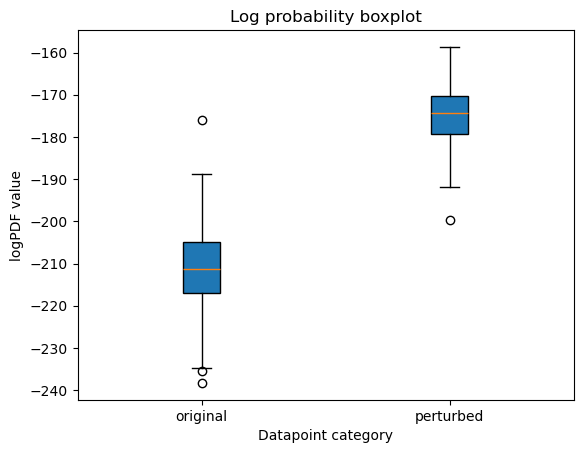

In [16]:
plt.boxplot(l, labels=['original','perturbed'], patch_artist=True)
# Add labels and title
plt.xlabel('Datapoint category')
plt.ylabel('logPDF value')
plt.title('Log probability boxplot')